100%|██████████| 350/350 [23:40<00:00,  4.06s/trial, best loss: 232.5362129959135] 
Best Hyperparameters: {'colsample_bytree': 0.7929790682209755, 'gamma': 0.6033273830178953, 'learning_rate': 0.09997699362356686, 'max_delta_step': 11.0, 'max_depth': 5.0, 'min_child_weight': 7.0, 'n_estimators': 725.0, 'reg_alpha': 0.01229815941335101, 'reg_lambda': 1.6610844533067748, 'subsample': 0.7569306903183027}

Model Performance
Test MSE: 114.05202707255177
Test RMSE: 10.679514365014533
Test MAE: 2.2248618603717785
Test R² Score: 0.687066376209259


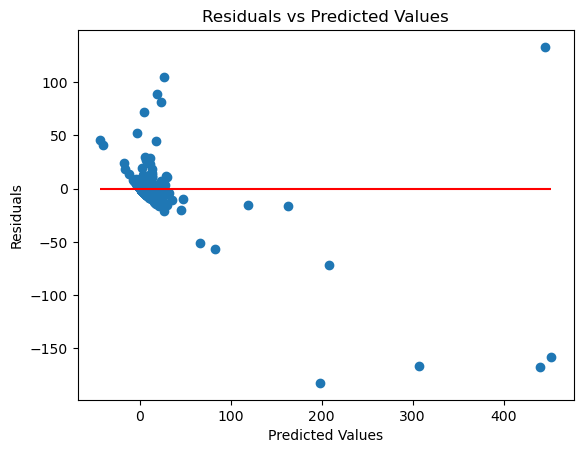

 98%|===================| 1710/1737 [00:17<00:00]        

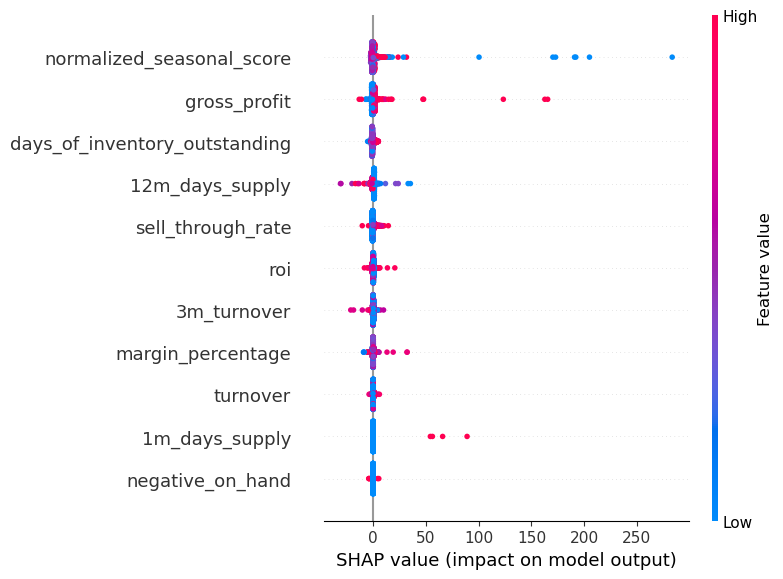

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from joblib import parallel_backend
import joblib
import numpy as np
import json
import shap

# Load data
df = pd.read_csv('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/processed_data/parts_data_prepared.csv')

# Define feature columns and target variable
feature_cols = [col for col in df.columns if col not in {'part_number', 'description', 'supplier_name',
                                                         'sales_last_jan','sales_last_feb', 'sales_last_mar', 'sales_last_apr', 'sales_last_may',
                                                         'sales_last_jun', 'sales_last_jul', 'sales_last_aug', 'sales_last_sep',
                                                         'sales_last_oct', 'sales_last_nov', 'sales_last_dec', 'sales_jan',
                                                         'sales_feb', 'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 
                                                         'sales_jul', 'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 
                                                         'sales_dec', 'sales_revenue', 'cogs', 'rolling_12m_sales', 'rolling_3m_sales',
                                                         'margin', 'price', 'quantity', 'cost_per_unit', 'months_no_sale', 'total_cost'}]

mask = df['months_no_sale'] >=12                          
X = df[~mask][feature_cols]
y = df[~mask]['rolling_12m_sales']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Define preprocessing pipeline
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', RobustScaler()),
            ('power_trans', PowerTransformer(method='yeo-johnson'))]),
        numerical_features)
    ])

# Define space for Hyperopt
space = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.8),
    'gamma': hp.uniform('gamma', 0.5, 0.8),  
    'learning_rate': hp.uniform('learning_rate', 0.025, 0.1),  
    'max_depth': hp.quniform('max_depth', 5, 10, 1), 
    'min_child_weight': hp.quniform('min_child_weight', 7, 10, 1),  
    'n_estimators': hp.quniform('n_estimators', 250, 800, 25),  
    'reg_alpha': hp.uniform('reg_alpha', 0.005, 0.1),  
    'reg_lambda': hp.uniform('reg_lambda', 1.5, 3.0),  
    'subsample': hp.uniform('subsample', 0.75, 1.0),  
    'max_delta_step': hp.quniform('max_delta_step', 6, 11, 1),  
}

# Set up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42) 

# Define the scoring function
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Define the objective function for Hyperopt
def objective(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_child_weight'] = int(params['min_child_weight'])
    params['max_delta_step'] = int(params['max_delta_step']) 

    # Define the model
    model = XGBRegressor(**params)
    
    # Define the full pipeline without RFECV
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Perform cross-validation
    with parallel_backend('threading'):
        scores = cross_val_score(pipeline, X_train, y_train, scoring=scorer, cv=kf)
    return {'loss': -scores.mean(), 'status': STATUS_OK}

# Run the optimization
trials = Trials()
best_hyperparams = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=350, trials=trials)  

print("Best Hyperparameters:", best_hyperparams)

# Correctly casting the best hyperparameters to their correct types
best_hyperparams['n_estimators'] = int(best_hyperparams['n_estimators'])
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams['max_delta_step'] = int(best_hyperparams['max_delta_step'])
best_hyperparams['min_child_weight'] = int(best_hyperparams['min_child_weight'])

# Train the model with the best hyperparameters
final_model = XGBRegressor(**best_hyperparams)

# Perform feature selection with RFECV using the optimal hyperparameters
rfecv = RFECV(estimator=final_model, step=1, cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)

# Define the final pipeline with RFECV and optimal hyperparameters
feature_selection_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', rfecv)
])

# Fit the feature selection pipeline
feature_selection_pipeline.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[feature_selection_pipeline.named_steps['feature_selector'].support_]

# Define the final preprocessor for selected features
final_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', RobustScaler()),
            ('power_trans', PowerTransformer())
        ]), selected_features)
    ]
)

# Define the final model pipeline with selected features
final_pipeline = Pipeline([
    ('preprocessor', final_preprocessor),
    ('regressor', final_model)
])

# Fit the final pipeline on the selected features
final_pipeline.fit(X_train[selected_features], y_train)

# Save the selected features and the best hyperparameters to a JSON file
results_dict = {
    "selected_features": selected_features.tolist(),
    "best_hyperparameters": best_hyperparams
}

with open('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/Dashboard/Models/demand_predictor/general_model_details.json', 'w') as fp:
    json.dump(results_dict, fp, indent=4)

# Save the final pipeline for application
joblib.dump(final_pipeline, '/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/dashboard/models/demand_predictor/xgb_regressor_with_selected_features.joblib')

# Evaluate the model
X_test_transformed = final_pipeline.named_steps['preprocessor'].transform(X_test[selected_features])
y_pred = final_pipeline.named_steps['regressor'].predict(X_test_transformed)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'\nModel Performance')
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R² Score: {r2}")

# Plot residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

# SHAP analysis
explainer = shap.Explainer(final_model, X_test_transformed)
shap_values = explainer(X_test_transformed)

# Optionally, you can visualize the SHAP values
shap.summary_plot(shap_values, X_test_transformed, feature_names=selected_features)

# Save SHAP values
shap_df = pd.DataFrame(shap_values.values, columns=selected_features)
shap_df.to_csv('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/Dashboard/Models/demand_predictor/shap_values.csv', index=False)



In [18]:
# Load the hyperparameters from the JSON file
with open('/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/Dashboard/Models/demand_predictor/general_model_details.json', 'r') as file:
    hyperparameters = json.load(file)

# Print the hyperparameters
print("Hyperparameters saved in the JSON file:")
print(hyperparameters)

Hyperparameters saved in the JSON file:
{'selected_features': ['normalized_seasonal_score', 'negative_on_hand', 'margin_percentage', 'gross_profit', 'roi', '12m_days_supply', '1m_days_supply', 'turnover', '3m_turnover', 'sell_through_rate', 'days_of_inventory_outstanding'], 'best_hyperparameters': {'colsample_bytree': 0.7929790682209755, 'gamma': 0.6033273830178953, 'learning_rate': 0.09997699362356686, 'max_delta_step': 11, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 725, 'reg_alpha': 0.01229815941335101, 'reg_lambda': 1.6610844533067748, 'subsample': 0.7569306903183027}}


In [28]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Load the data
df = pd.read_csv("/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/data/processed_data/parts_data_prepared.csv")

# Select the features (X) and target (y) for modeling
feature_cols = [col for col in df.columns if col not in {'part_number', 'description', 'supplier_name',
                                                         'sales_last_jan','sales_last_feb', 'sales_last_mar', 'sales_last_apr', 'sales_last_may',
                                                         'sales_last_jun', 'sales_last_jul', 'sales_last_aug', 'sales_last_sep',
                                                         'sales_last_oct', 'sales_last_nov', 'sales_last_dec', 'sales_jan',
                                                         'sales_feb', 'sales_mar', 'sales_apr', 'sales_may', 'sales_jun', 
                                                         'sales_jul', 'sales_aug', 'sales_sep', 'sales_oct', 'sales_nov', 
                                                         'sales_dec', 'sales_revenue', 'cogs', 'price', 'rolling_12m_sales'}]
X = df[feature_cols]

# Add a constant to the DataFrame
df = sm.add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

# Display the VIF for each feature
print(vif_data)


                          feature        VIF
0                           const  12.488638
1       normalized_seasonal_score   2.540796
2                        quantity   5.002715
3                  months_no_sale   1.079207
4            quantity_ordered_ytd   1.064776
5                negative_on_hand   1.163495
6                          margin   3.376943
7              special_orders_ytd   1.041023
8                   cost_per_unit   3.106045
9                      total_cost   1.280671
10              margin_percentage   1.177468
11                   gross_profit   1.734802
12                            roi   1.043944
13               rolling_3m_sales   3.511741
14                12m_days_supply   4.011494
15                 3m_days_supply   4.446802
16                 1m_days_supply   4.611917
17                       turnover   1.017243
18                    3m_turnover   1.044536
19              sell_through_rate   1.128851
20  days_of_inventory_outstanding   1.441075
21        

In [5]:
import joblib
import json
import logging

# Define file paths
PREPROCESSOR_PATH = '/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/dashboard/models/demand_predictor/preprocessor.joblib'
MODEL_PATH = '/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/dashboard/models/demand_predictor/xgb_regressor_with_selected_features.joblib'
MODEL_INFO_PATH = '/Users/skylerwilson/Desktop/PartsWise/co-pilot-v1/dashboard/models/demand_predictor/general_model_details.json'

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

def print_preprocessor_details(preprocessor_path):
    try:
        preprocessor = joblib.load(preprocessor_path)
        logging.info("Preprocessor loaded successfully.")
        print("Preprocessor Structure:")
        print(preprocessor)
    except Exception as e:
        logging.error(f"Failed to load preprocessor: {e}")

def print_model_details(model_path):
    try:
        model = joblib.load(model_path)
        logging.info("Model loaded successfully.")
        print("Model Details:")
        print(model)
        print("Feature Importances (if available):")
        print(getattr(model, 'feature_importances_', 'Not available'))
    except Exception as e:
        logging.error(f"Failed to load model: {e}")

def print_json_configuration(model_info_path):
    try:
        with open(model_info_path, 'r') as file:
            model_info = json.load(file)
        logging.info("Model configuration loaded successfully.")
        print("Model Configuration:")
        print(json.dumps(model_info, indent=4))
    except Exception as e:
        logging.error(f"Failed to load model configuration JSON: {e}")

def main():
    print_preprocessor_details(PREPROCESSOR_PATH)
    print_model_details(MODEL_PATH)
    print_json_configuration(MODEL_INFO_PATH)

if __name__ == "__main__":
    main()


2024-07-19 17:37:10,558 - Preprocessor loaded successfully.
2024-07-19 17:37:10,596 - Model loaded successfully.
2024-07-19 17:37:10,613 - Model configuration loaded successfully.


Preprocessor Structure:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', RobustScaler()),
                                                 ('power_trans',
                                                  PowerTransformer())]),
                                 Index(['normalized_seasonal_score', 'negative_on_hand', 'quantity_ordered_ytd',
       'special_orders_ytd', 'total_cost', 'margin_percentage', 'gross_profit',
       'roi', '12m_days_supply', '3m_days_supply', '1m_days_supply',
       'turnover', '3m_turnover', 'sell_through_rate',
       'days_of_inventory_outstanding', 'order_to_sales_ratio'],
      dtype='object'))])
Model Details:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler()),
                                                